In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
def get_structured_data(data,label):
    #provides the final structured data for modeling 
    features = data.iloc[:,[x for x in range(10,24)]]
    target = data[label]
    structured_data = pd.concat([features, target], axis=1, sort=False)
    structured_data = remove_duplicates(structured_data)
    return structured_data

def remove_duplicates(data):
    data = data.drop_duplicates(subset=['request category','D1(Small), D2(Medium)', 'D3', 'D4', 'D5(Small)', 'D6(Large)', 'D7',
       'D8', 'D9', 'D10', 'D12(Small), D13(Medium)', 'D14', 'D15', 'D16'])
    return data

In [16]:
#import data
data = pd.read_csv('Generated Data/final_data.csv', encoding='utf-8')
delete_columns = ['Name','fail_count','Median response time','D11','Hatch Rate','Time', 'variant_cost_hr']
data = data.drop(delete_columns, axis=1)

#Train-test split
structured_data =  get_structured_data(data, "mean_rt")

X = structured_data.iloc[:, 0:14]  #Feature Matrix
Y = structured_data.iloc[:, -1] #Target Variable

In [25]:
#Baseline Model
def base_RFR(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    base_RFR = RandomForestRegressor()
    base_RFR.fit(X_train, y_train)
    y_pred = base_RFR.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    print('R-Square: ', r2)
    print('MSE: ', mean_squared_error(y_test,y_pred))
    
base_RFR(X, Y)

R-Square:  0.7675653682247942
MSE:  15118472.891936664


In [28]:
def perfrom_RFR_GridSearch(X,Y, trees, sizes):    
    scores = []
    best_tree = []
    best_feat = []

    for size in sizes:
        param_hist = pd.DataFrame()
        mx_feat = []
        n_trees = []
        r2_sc = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)

        for x in trees:
            for d  in range(1,15):
                rnd_forest_Reg = RandomForestRegressor(n_estimators=x, max_features=d)
                rnd_forest_Reg.fit(X_train, y_train)
                y_pred = rnd_forest_Reg.predict(X_test)
                r2 = r2_score(y_test,y_pred)
                n_trees.append(x)
                mx_feat.append(d)
                r2_sc.append(r2)

        param_hist = pd.DataFrame(list(zip(n_trees, mx_feat, r2_sc)), columns =['n_estimators', 'max_features', 'r2_score'])
        best_params = param_hist.iloc[param_hist['r2_score'].idxmax()]

        best_tree.append(int(best_params[0]))
        best_feat.append(int(best_params[1]))
        scores.append(round(best_params[2],2))
    size_score = pd.DataFrame(list(zip([1-s for s in sizes], scores, best_tree, best_feat)), columns=['train_size','r2_score','no_trees','max_features'])
    
    return size_score

In [29]:
trees = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
sizes = [0.1,0.2,0.3,0.4,0.5]
size_score = perfrom_RFR_GridSearch(X,Y, trees, sizes)

In [30]:
best = size_score.iloc[size_score['r2_score'].idxmax()]
bes_n_est = int(best[2])
best_mx_feat = int(best[3])
best_train_size = round(1-best[0],2)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=best_train_size, random_state=42)
rfReg = RandomForestRegressor(n_estimators=bes_n_est, max_features=best_mx_feat)
rfReg.fit(X_train, y_train)
y_pred = rfReg.predict(X_test)
print("R2 score: ",round(r2_score(y_test,y_pred),3))

R2 score:  0.915


In [31]:
#size_score.to_csv("_train_size.csv", encoding='utf-8')

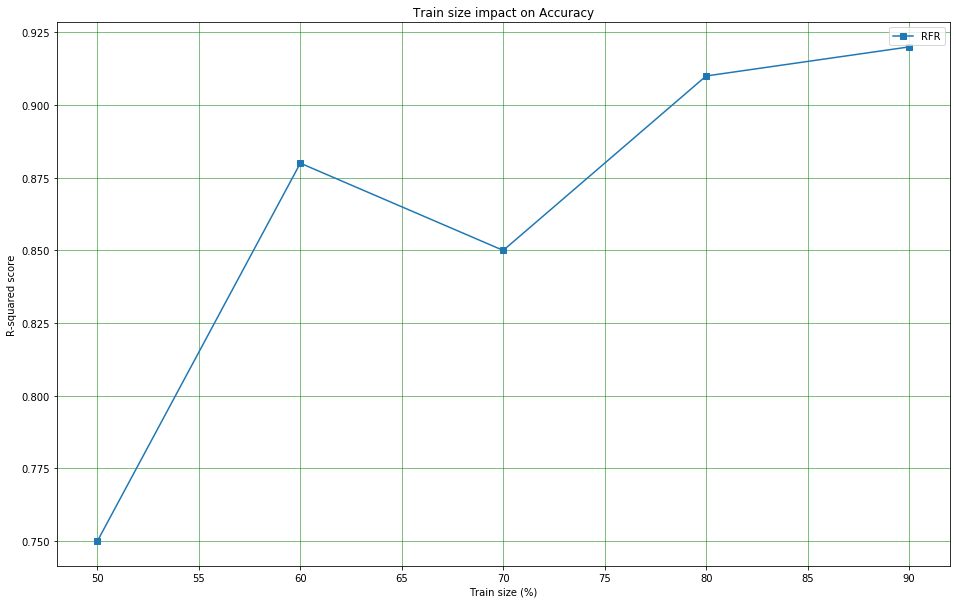

In [32]:
size_fig = plt.figure(figsize=(16,10))
plt.plot(size_score.train_size.values*100, size_score.r2_score, '-s', label = "RFR", )
plt.grid( linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Train size (%)')
plt.ylabel('R-squared score')
plt.title('Train size impact on Accuracy')
plt.legend()


In [33]:
# plt.figure(figsize=(16,10))
# ax1 = sns.distplot(dept_df['y'], hist=False, color='r', kde_kws={'linewidth':2},  label="Actual Value", )

# for x in [100, 200, 400, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
#     sns.distplot(dept_df[str(x)+"_trees"], kde_kws={'linewidth':2,'linestyle':'--'}, hist=False,  label="Prediction at "+str(x)+" trees")
# sns.distplot(dept_df[str(600)+"_trees"], hist=False, color='b', kde_kws={'linewidth':2}, label="Chosen no. trees "+str(600))
# plt.xlabel("Predicted moving Mean RT")
# plt.ylabel("")
# plt.title('Prediction accuracy at every n_estimator')
# plt.savefig("RFR_accuracy.png")